## Setup

In [1]:
import sys

sys.path.append("..")

import tensorflow as tf

import numpy as np

import GPyOpt

import argparse

from utils import tf_config, preprocess_data, search_algorithms, train

from models import fmri_ae, eeg_to_fmri, uniconv_fmri

from layers import locally_connected, topographical_attention

import matplotlib.pyplot as plt

import gc

import os

from sklearn.model_selection import train_test_split, KFold

import time

dataset="01"
memory_limit=1500
n_individuals=8
interval_eeg=6

tf_config.set_seed(seed=42)
tf_config.setup_tensorflow(device="GPU", memory_limit=memory_limit)

with tf.device('/CPU:0'):
    train_data, _ = preprocess_data.dataset(dataset, n_individuals=n_individuals, 
                                            interval_eeg=interval_eeg, 
                                            ind_volume_fit=False,
                                            standardize_fmri=False,
                                            iqr=False,
                                            verbose=True)
    eeg_train, _ =train_data
    
    train_x, val_x = train_test_split(eeg_train, test_size=0.2, shuffle=True, random_state=42)

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy
I: Starting to Load Data
I: Finished Loading Data
I: Pairs Created


## Hyperparameters and dataset creation

In [2]:
batch_size=16
learning_rate=0.0001
skip_connections=True
maxpool=True
batch_norm=True
weight_decay=1e-5
n_channels=16
latent_dimension=(5,5,5)
kernel_size=(9,9,4)
stride_size=(1,1,1)
encoding_kernel_size=(3,3,3)
encoding_stride_size=(1,1,1)
n_stacks=3

optimizer = tf.keras.optimizers.Adam(learning_rate)
loss_fn = tf.keras.losses.MSE

train_set = tf.data.Dataset.from_tensor_slices((train_x, train_x)).batch(batch_size)
dev_set = tf.data.Dataset.from_tensor_slices((val_x, val_x)).batch(1)

## Playing around with attention

In [3]:

layers = []

#Input layer
layers += [tf.keras.layers.Input(train_x.shape[1:])]

#reshape to flattened features to apply attention mechanism
layers += [tf.keras.layers.Reshape((train_x.shape[1],train_x.shape[2]*train_x.shape[3]))]

#topographical attention
layers += [topographical_attention.Topographical_Attention(train_x.shape[1], train_x.shape[2]*train_x.shape[3])]

#reshape back to original shape
layers += [tf.keras.layers.Reshape(train_x.shape[1:])]


model = tf.keras.Sequential(layers)
model.build(input_shape=train_x.shape)

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 64, 804)           0         
_________________________________________________________________
topographical__attention (To (None, 64, 804)           3293184   
_________________________________________________________________
reshape_1 (Reshape)          (None, 64, 134, 6, 1)     0         
Total params: 3,293,184
Trainable params: 3,293,184
Non-trainable params: 0
_________________________________________________________________


In [17]:
model(train_x[1:2])

<tf.Tensor: shape=(1, 64, 134, 6, 1), dtype=float32, numpy=
array([[[[[ 0.06019989],
          [ 0.05126164],
          [ 0.03599019],
          [ 0.06049407],
          [ 0.00113363],
          [ 0.05415447]],

         [[ 0.0642464 ],
          [ 0.06025197],
          [ 0.05123733],
          [ 0.05866933],
          [ 0.06162269],
          [ 0.05949799]],

         [[ 0.06540798],
          [ 0.06409635],
          [ 0.0637676 ],
          [ 0.06072949],
          [ 0.05883442],
          [ 0.06291339]],

         ...,

         [[ 0.02226114],
          [ 0.01604581],
          [ 0.00358203],
          [ 0.03500372],
          [-0.03401611],
          [-0.02920715]],

         [[ 0.01977284],
          [ 0.00636961],
          [ 0.03835049],
          [ 0.00059377],
          [-0.0429195 ],
          [-0.02269086]],

         [[ 0.02946451],
          [ 0.02238912],
          [ 0.04383809],
          [ 0.0543658 ],
          [-0.02523522],
          [ 0.00752145]]],


        [[[

## Drawing the attention graph

In [20]:
import networkx as nx


model.layers[1].attention_scores.numpy().shape

(1, 64, 64)

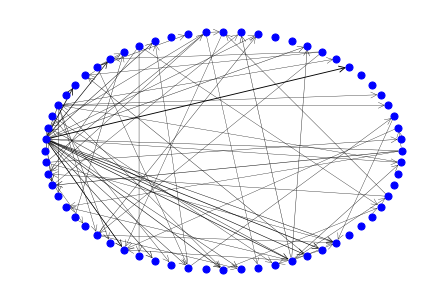

In [95]:
channels=train_x.shape[1]

G = nx.DiGraph(directed=True)

batch=0

for node in range(model.layers[1].attention_scores.shape[1]):
    G.add_node(str(node))

mean_weight = np.mean(model.layers[1].attention_scores.numpy()[batch,:,:])
std_weight = np.std(model.layers[1].attention_scores.numpy()[batch,:,:])
for node_src in range(model.layers[1].attention_scores.shape[1]):
    for node_tg in range(model.layers[1].attention_scores.shape[2]):
        if(model.layers[1].attention_scores.numpy()[batch,node_src,node_tg] > mean_weight + 2*std_weight):
            G.add_edge(str(node_src), str(node_tg), weight=15.0*model.layers[1].attention_scores.numpy()[batch,node_src,node_tg])
        

channels=train_x.shape[1]

colors = range(channels*channels)


options = {
    'node_color': 'blue',
    'node_size': 50,
    'arrowstyle': '->',
    'arrowsize': 15,
}


weights = nx.get_edge_attributes(G,'weight').values()

edges = G.edges()

nx.draw_circular(G, width=list(weights), **options)
plt.show()


range(0, 20)
{0: array([-0.00145903, -0.00385528]), 1: array([ 0.82927063, -0.56749417]), 2: array([0.78340975, 0.62043387]), 3: array([0.44350827, 0.88602275]), 4: array([0.57038198, 0.29264152]), 5: array([-0.60270972, -0.80594719]), 6: array([0.9787102 , 0.17911605]), 7: array([ 0.88117148, -0.18071823]), 8: array([-0.87386136, -0.09542477]), 9: array([ 0.44904702, -0.44770212]), 10: array([-0.54528564,  0.31786046]), 11: array([-0.96760477,  0.26770483]), 12: array([-0.37717626,  0.82685252]), 13: array([-0.40078389, -0.4770624 ]), 14: array([-0.87591412, -0.44782003]), 15: array([0.10573802, 0.62589944]), 16: array([ 0.09113824, -0.79062835]), 17: array([-0.02161914,  1.        ]), 18: array([ 0.46225743, -0.89067674]), 19: array([-0.19203854, -0.99101022]), 20: array([-0.73618056,  0.68180805])}


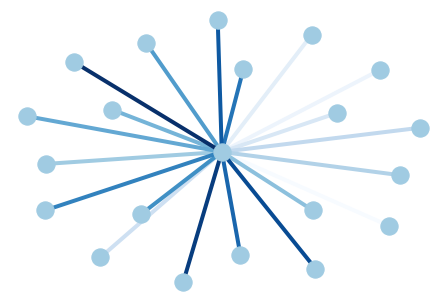

In [33]:
G = nx.star_graph(20)
pos = nx.spring_layout(G)
colors = range(20)
options = {
    "node_color": "#A0CBE2",
    "edge_color": colors,
    "width": 4,
    "edge_cmap": plt.cm.Blues,
    "with_labels": False,
}
nx.draw(G, pos, **options)
plt.show()


In [1]:

import mne
import matplotlib.pyplot as plt

eeg_export_32 = mne.io.read_raw_brainvision("/home/david/eeg_to_fmri/datasets/01/EEG/32/export/20130410320002_Segmentation_bin.vhdr", preload=True, verbose=0)
#eeg_raw_32 = mne.io.read_raw_brainvision("/home/david/eeg_to_fmri/datasets/01/EEG/32/raw/20130410320002.vhdr", preload=True, verbose=0)

eeg_export_35 = mne.io.read_raw_brainvision("/home/david/eeg_to_fmri/datasets/01/EEG/35/export/20130424350002_Pulse_Artifact_Correction_bin.vhdr", preload=True, verbose=0)
eeg_export_36 = mne.io.read_raw_brainvision("/home/david/eeg_to_fmri/datasets/01/EEG/36/export/20130425360002_Pulse_Artifact_Correction_bin.vhdr", preload=True, verbose=0)
eeg_export_37 = mne.io.read_raw_brainvision("/home/david/eeg_to_fmri/datasets/01/EEG/37/export/20130426370002_Pulse_Artifact_Correction_bin.vhdr", preload=True, verbose=0)
eeg_export_38 = mne.io.read_raw_brainvision("/home/david/eeg_to_fmri/datasets/01/EEG/38/export/20130105380002_Pulse_Artifact_Correction_bin.vhdr", preload=True, verbose=0)
eeg_export_39 = mne.io.read_raw_brainvision("/home/david/eeg_to_fmri/datasets/01/EEG/39/export/20130501390002_Pulse_Artifact_Correction_bin.vhdr", preload=True, verbose=0)
eeg_export_40 = mne.io.read_raw_brainvision("/home/david/eeg_to_fmri/datasets/01/EEG/40/export/20130510400002_Pulse_Artifact_Correction_bin.vhdr", preload=True, verbose=0)
eeg_export_42 = mne.io.read_raw_brainvision("/home/david/eeg_to_fmri/datasets/01/EEG/42/export/20130523420002_Pulse_Artifact_Correction_bin.vhdr", preload=True, verbose=0)
eeg_export_43 = mne.io.read_raw_brainvision("/home/david/eeg_to_fmri/datasets/01/EEG/43/export/20130529430002_Pulse_Artifact_Correction_bin.vhdr", preload=True, verbose=0)
eeg_export_44 = mne.io.read_raw_brainvision("/home/david/eeg_to_fmri/datasets/01/EEG/44/export/20130605440002_Pulse_Artifact_Correction_bin.vhdr", preload=True, verbose=0)
eeg_export_45 = mne.io.read_raw_brainvision("/home/david/eeg_to_fmri/datasets/01/EEG/45/export/20130627450002_Pulse_Artifact_Correction_bin.vhdr", preload=True, verbose=0)
eeg_export_46 = mne.io.read_raw_brainvision("/home/david/eeg_to_fmri/datasets/01/EEG/46/export/20130703460002_Pulse_Artifact_Correction_bin.vhdr", preload=True, verbose=0)
eeg_export_47 = mne.io.read_raw_brainvision("/home/david/eeg_to_fmri/datasets/01/EEG/47/export/20130710470002_Pulse_Artifact_Correction_bin.vhdr", preload=True, verbose=0)
eeg_export_48 = mne.io.read_raw_brainvision("/home/david/eeg_to_fmri/datasets/01/EEG/48/export/20130717480002_Pulse_Artifact_Correction_bin.vhdr", preload=True, verbose=0)
eeg_export_49 = mne.io.read_raw_brainvision("/home/david/eeg_to_fmri/datasets/01/EEG/49/export/20130918490002_Pulse_Artifact_Correction_bin.vhdr", preload=True, verbose=0)
eeg_export_50 = mne.io.read_raw_brainvision("/home/david/eeg_to_fmri/datasets/01/EEG/50/export/20131003_500002_Pulse_Artifact_Correction_bin.vhdr", preload=True, verbose=0)


<ipython-input-1-725864d7f9f9>:4: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  eeg_export_32 = mne.io.read_raw_brainvision("/home/david/eeg_to_fmri/datasets/01/EEG/32/export/20130410320002_Segmentation_bin.vhdr", preload=True, verbose=0)
<ipython-input-1-725864d7f9f9>:7: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  eeg_export_35 = mne.io.read_raw_brainvision("/home/david/eeg_to_fmri/datasets/01/EEG/35/export/20130424350002_Pulse_Artifact_Correction_bin.vhdr", preload=True, verbose=0)
<ipython-input-1-725864d7f9f9>:8: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  eeg_export_36 = mne.io.read_raw_brainvision("/home/david/eeg_to_fmri/datasets/01/EEG/36/export/2013

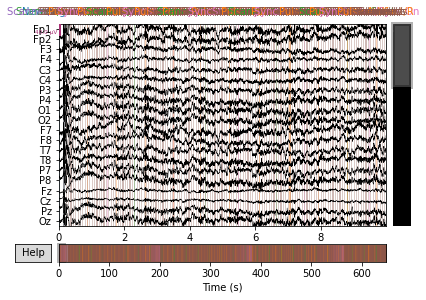

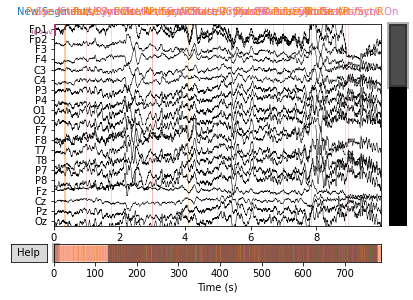

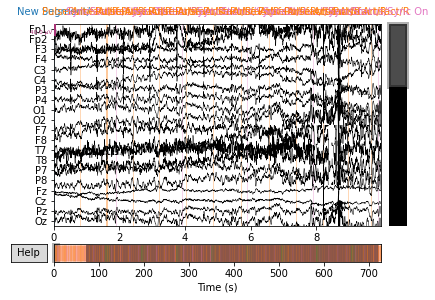

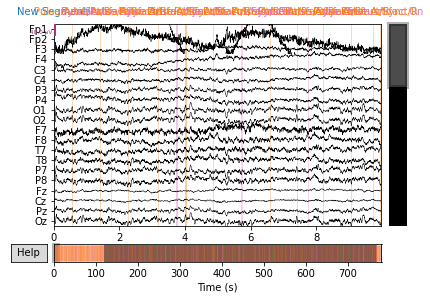

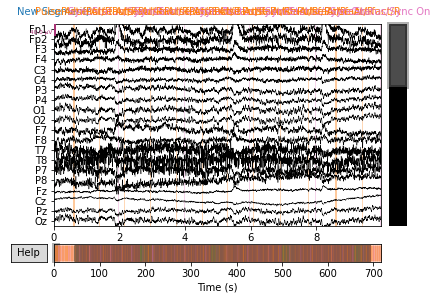

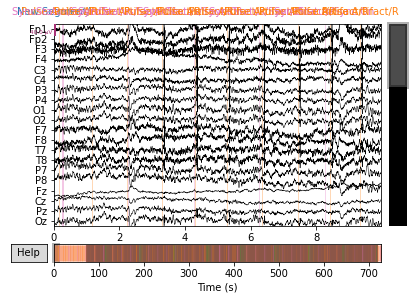

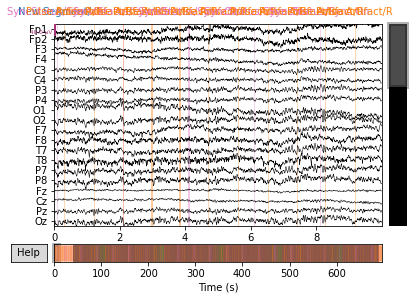

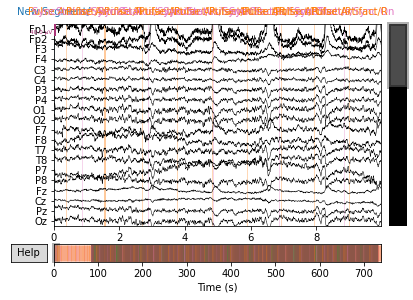

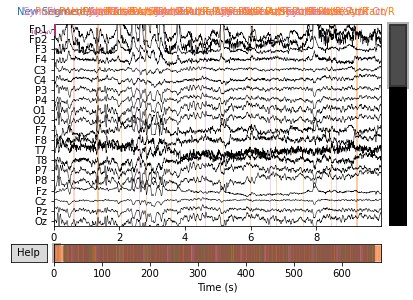

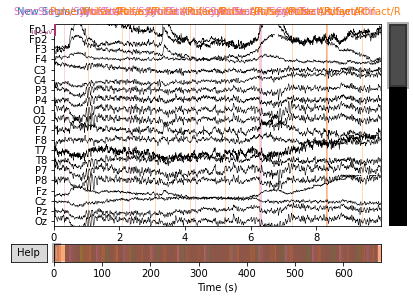

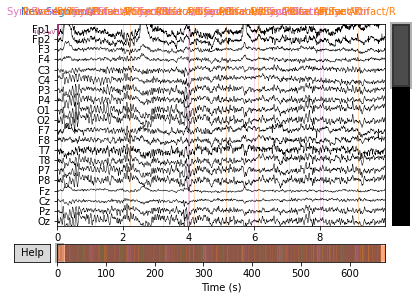

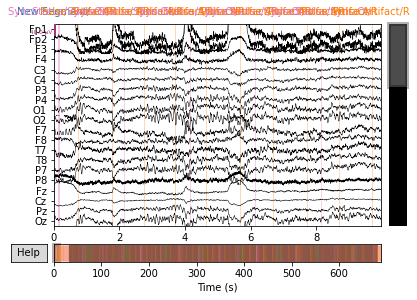

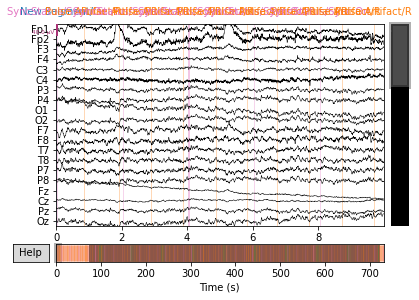

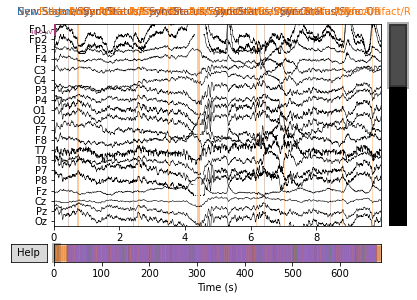

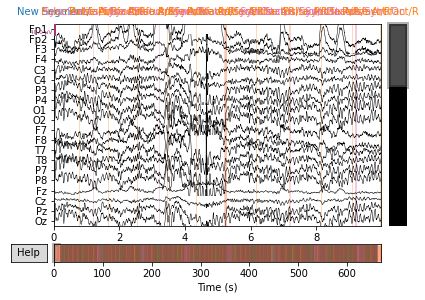

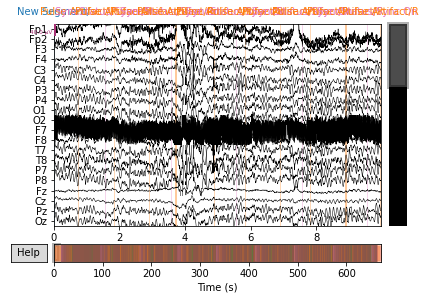

In [2]:
mne.viz.plot_raw(eeg_export_32)
plt.show()

mne.viz.plot_raw(eeg_export_35)
plt.show()

mne.viz.plot_raw(eeg_export_36)
plt.show()

mne.viz.plot_raw(eeg_export_37)
plt.show()

mne.viz.plot_raw(eeg_export_38)
plt.show()

mne.viz.plot_raw(eeg_export_39)
plt.show()

mne.viz.plot_raw(eeg_export_40)
plt.show(

mne.viz.plot_raw(eeg_export_42)
plt.show()

mne.viz.plot_raw(eeg_export_43)
plt.show()

mne.viz.plot_raw(eeg_export_44)
plt.show()

mne.viz.plot_raw(eeg_export_45)
plt.show()

mne.viz.plot_raw(eeg_export_46)
plt.show()

mne.viz.plot_raw(eeg_export_47)
plt.show()

mne.viz.plot_raw(eeg_export_48)
plt.show()

mne.viz.plot_raw(eeg_export_49)
plt.show()

mne.viz.plot_raw(eeg_export_50)
plt.show()

In [92]:
from utils import eeg_utils
from scipy.ndimage import rotate

import importlib
importlib.reload(eeg_utils)

channel=41
windows=200


#f, Zxx, t = eeg_utils.stft(eeg_export_32, channel=channel, window_size=2)
Zxx = eeg_utils.dwt(eeg_export_32,channel=channel, windows=windows)
plt.imshow(rotate(Zxx, 180))
plt.show()


#f, Zxx, t = eeg_utils.stft(eeg_export_35, channel=channel, window_size=2)
Zxx = eeg_utils.dwt(eeg_export_35,channel=channel, windows=windows)
plt.imshow(rotate(Zxx, 180))
plt.show()


#f, Zxx, t = eeg_utils.stft(eeg_export_36, channel=channel, window_size=2)
Zxx = eeg_utils.dwt(eeg_export_36,channel=channel, windows=windows)
plt.imshow(rotate(Zxx, 180))
plt.show()


#f, Zxx, t = eeg_utils.stft(eeg_export_37, channel=channel, window_size=2)
Zxx = eeg_utils.dwt(eeg_export_37,channel=channel, windows=windows)
plt.imshow(rotate(Zxx, 180))
plt.show()


#f, Zxx, t = eeg_utils.stft(eeg_export_38, channel=channel, window_size=2)
Zxx = eeg_utils.dwt(eeg_export_38,channel=channel, windows=windows)
plt.imshow(rotate(Zxx, 180))
plt.show()


#f, Zxx, t = eeg_utils.stft(eeg_export_39, channel=channel, window_size=2)
Zxx = eeg_utils.dwt(eeg_export_39,channel=channel, windows=windows)
plt.imshow(rotate(Zxx, 180))
plt.show()


#f, Zxx, t = eeg_utils.stft(eeg_export_40, channel=channel, window_size=2)
Zxx = eeg_utils.dwt(eeg_export_40,channel=channel, windows=windows)
plt.imshow(rotate(Zxx, 180))
plt.show()


#f, Zxx, t = eeg_utils.stft(eeg_export_42, channel=channel, window_size=2)
Zxx = eeg_utils.dwt(eeg_export_42,channel=channel, windows=windows)
plt.imshow(rotate(Zxx, 180))
plt.show()

#f, Zxx, t = eeg_utils.stft(eeg_export_43, channel=channel, window_size=2)
Zxx = eeg_utils.dwt(eeg_export_43,channel=channel, windows=windows)
plt.imshow(rotate(Zxx, 180))
plt.show()

#f, Zxx, t = eeg_utils.stft(eeg_export_44, channel=channel, window_size=2)
Zxx = eeg_utils.dwt(eeg_export_44,channel=channel, windows=windows)
plt.imshow(rotate(Zxx, 180))
plt.show()

#f, Zxx, t = eeg_utils.stft(eeg_export_45, channel=channel, window_size=2)
Zxx = eeg_utils.dwt(eeg_export_45,channel=channel, windows=windows)
plt.imshow(rotate(Zxx, 180))
plt.show()

#f, Zxx, t = eeg_utils.stft(eeg_export_46, channel=channel, window_size=2)
Zxx = eeg_utils.dwt(eeg_export_46,channel=channel, windows=windows)
plt.imshow(rotate(Zxx, 180))
plt.show()

#f, Zxx, t = eeg_utils.stft(eeg_export_47, channel=channel, window_size=2)
Zxx = eeg_utils.dwt(eeg_export_47,channel=channel, windows=windows)
plt.imshow(rotate(Zxx, 180))
plt.show()

#f, Zxx, t = eeg_utils.stft(eeg_export_48, channel=channel, window_size=2)
Zxx = eeg_utils.dwt(eeg_export_48,channel=channel, windows=windows)
plt.imshow(rotate(Zxx, 180))
plt.show()

#f, Zxx, t = eeg_utils.stft(eeg_export_49, channel=channel, window_size=2)
Zxx = eeg_utils.dwt(eeg_export_49,channel=channel, windows=windows)
plt.imshow(rotate(Zxx, 180))
plt.show()

#f, Zxx, t = eeg_utils.stft(eeg_export_50, channel=channel, window_size=2)
Zxx = eeg_utils.dwt(eeg_export_50,channel=channel, windows=windows)
plt.imshow(rotate(Zxx, 180))
plt.show()

KeyboardInterrupt: 

In [126]:
channel=25
windows=300

print(len(eeg_export_32[channel][1]))

Zxx = eeg_utils.dwt(eeg_export_32,channel=channel, windows=windows)
Zxx = np.abs(Zxx)
Zxx.shape

162023


(299, 162023)

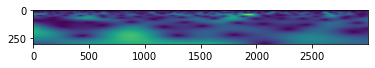

In [127]:
n=6
plt.imshow(Zxx[:,n*(250*12):(n+1)*(250*12)])

250.0